In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft
from scipy.signal import correlate2d
import librosa
import librosa.display
np.random.seed(42)

In [ ]:
sample_rate = 22050
duration = 4.0
t = np.linspace(0, duration, int(sample_rate * duration), endpoint=False)

song = (
    np.sin(2 * np.pi * 440 * t) +
    0.5 * np.sin(2 * np.pi * 880 * t)
)


In [ ]:

def plot(t,song,instance_limit):
    plt.figure(figsize=(10, 3))
    plt.plot(t[:instance_limit], song[:instance_limit])
    plt.title(f"Original waveform till {instance_limit}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [ ]:
def get_song(song,duration_to_use):
    max_samples = int(sample_rate * duration_to_use)
    return song[:max_samples]

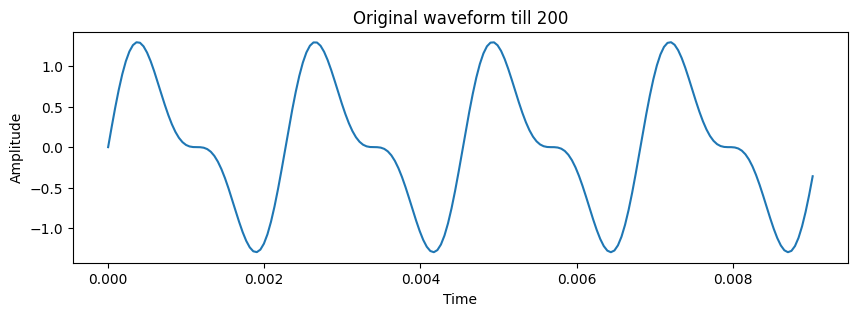

In [ ]:
plot(t,song,200)

In [ ]:
def spectrogram(signal, sr):
    f, t, Zxx = stft(signal, fs=sr, nperseg=1024)
    return np.abs(Zxx)

d:\code\SELF_MASTERS_CODEBASE\projects\shazam\shazzzzam\.venv\Lib\site-packages\scipy\signal\_spectral_py.py:1595: UserWarning: nperseg = 1024 is greater than input length  = 1000, using nperseg = 1000
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


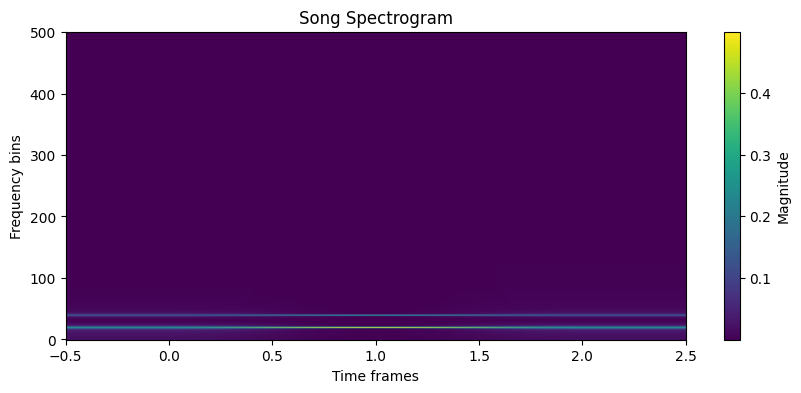

In [ ]:
S_song = spectrogram(song[:1000], sample_rate)
plt.figure(figsize=(10, 4))
plt.imshow(S_song, aspect="auto", origin="lower")
plt.title("Song Spectrogram")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.colorbar(label="Magnitude")
plt.show()

See a real song

In [ ]:
audio_path = '..\..\guitar.mp3'
song, sample_rate = librosa.load(audio_path, sr=None, mono=True)
print(f"Sample rate: {sample_rate} Hz")
print(f"Duration: {len(song) / sample_rate:.2f} seconds")
print(f"Number of samples: {len(song)}")

Sample rate: 44100 Hz
Duration: 10.58 seconds
Number of samples: 466560


In [ ]:
def get_song(song,duration_to_use):
    max_samples = int(sample_rate * duration_to_use)
    return song[:max_samples]

In [ ]:
truncated_song = get_song(song,0.01)
t = np.linspace(0, len(song) / sample_rate, len(truncated_song), endpoint=False)

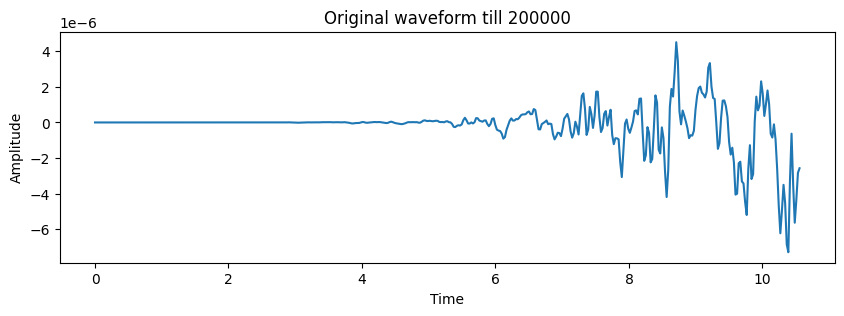

In [ ]:
plot(t,truncated_song,200000)

d:\code\SELF_MASTERS_CODEBASE\projects\shazam\shazzzzam\.venv\Lib\site-packages\scipy\signal\_spectral_py.py:1595: UserWarning: nperseg = 1024 is greater than input length  = 441, using nperseg = 441
  freqs, time, Zxx = _spectral_helper(x, x, fs, window, nperseg, noverlap,


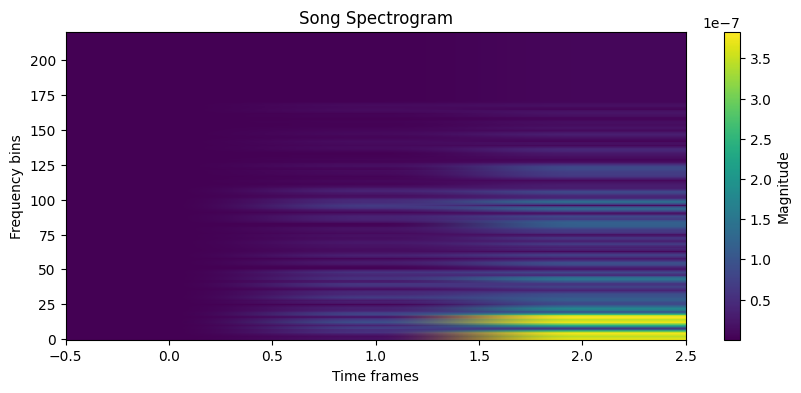

In [ ]:
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram(truncated_song, sample_rate), aspect="auto", origin="lower")
plt.title("Song Spectrogram")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.colorbar(label="Magnitude")
plt.show()

In [ ]:
audio_path = '..\..\drum.mp3'
song, sample_rate = librosa.load(audio_path, sr=None, mono=True)
print(f"Sample rate: {sample_rate} Hz")
print(f"Duration: {len(song) / sample_rate:.2f} seconds")
print(f"Number of samples: {len(song)}")

Sample rate: 44100 Hz
Duration: 11.34 seconds
Number of samples: 499968


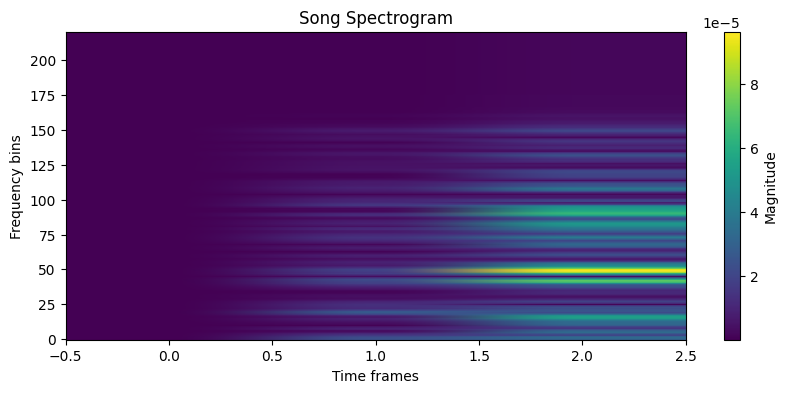

In [ ]:
truncated_song = get_song(song,0.01)
t = np.linspace(0, len(song) / sample_rate, len(truncated_song), endpoint=False)
plt.figure(figsize=(10, 4))
plt.imshow(spectrogram(truncated_song, sample_rate), aspect="auto", origin="lower")
plt.title("Song Spectrogram")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.colorbar(label="Magnitude")
plt.show()


Try subimage matching

In [ ]:
song_drums, sample_rate_drum = librosa.load("..\..\drum.mp3", sr=None, mono=True)
song_guitar, sample_rate_guitar = librosa.load("..\..\guitar.mp3", sr=None, mono=True)

clip_start_sec = 1
clip_len_sec = 1

start = int(sample_rate_guitar * clip_start_sec)
end = int(sample_rate_guitar * (clip_start_sec + clip_len_sec))
song_guitar_clip = song_guitar[start:end]

S_clip = spectrogram(song_guitar_clip, sample_rate_guitar)
S_drums = spectrogram(song_drums, sample_rate_drum)
S_guitar = spectrogram(song_guitar, sample_rate_guitar)

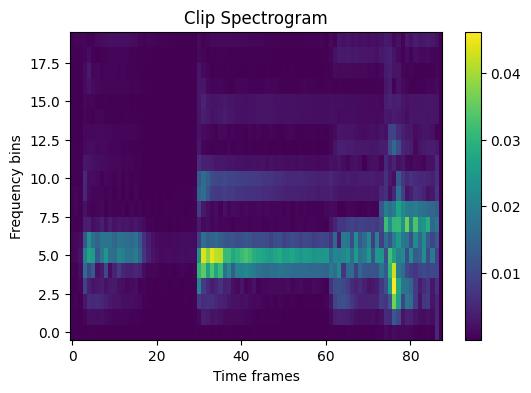

In [ ]:
plt.figure(figsize=(6, 4))
plt.imshow(S_clip[:20], aspect="auto", origin="lower")
plt.title("Clip Spectrogram")
plt.xlabel("Time frames")
plt.ylabel("Frequency bins")
plt.colorbar()
plt.show()

In [ ]:
def normalized_template_match(song_spec, clip_spec):
    song_mean = np.mean(song_spec)
    clip_mean = np.mean(clip_spec)
    song_norm = song_spec - song_mean
    clip_norm = clip_spec - clip_mean
    
    numer = correlate2d(song_norm, clip_norm, mode="valid")
    
    clip_energy = np.sum(clip_norm**2)
    
    ones_kernel = np.ones(clip_spec.shape)
    song_energy = correlate2d(song_norm**2, ones_kernel, mode="valid")
    denom = np.sqrt(song_energy * clip_energy)    
    denom[denom == 0] = 1
    norm_corr = numer / denom
    return np.max(norm_corr)  # Should be ~1.0 for perfect match

In [ ]:
print("Template match score with drums :", normalized_template_match(S_drums, S_clip))
print("Template match score with guitar :", normalized_template_match(S_guitar, S_clip))


Template match score with drums : 0.38586355001598477
Template match score with guitar : 0.9910047256086174


Okay so this method has some value , i read about this , seems like this has implementation in CV & is a standard method. However , this is clearly not scalable , how many correlations will we calculate & for how many images ?

Lets see if this method works with noise & echo 

In [ ]:
song_guitar, sample_rate_guitar = librosa.load("..\..\guitar.mp3", sr=None, mono=True)

clip_start_sec = 1
clip_len_sec = 1

start = int(sample_rate_guitar * clip_start_sec)
end = int(sample_rate_guitar * (clip_start_sec + clip_len_sec))
song_guitar_clip = song_guitar[start:end]

S_clip = spectrogram(song_guitar_clip, sample_rate_guitar)
S_guitar = spectrogram(song_guitar, sample_rate_guitar)

noise = 0.05 * np.random.randn(len(song_guitar_clip))
noisy_clip = song_guitar_clip + noise
#assert np.all(noisy_clip == song_guitar_clip)
S_noisy_clip = spectrogram(noisy_clip, sample_rate_guitar)

score_noisy = normalized_template_match(S_guitar, S_noisy_clip)
print("Template match score (noisy):", score_noisy)

Template match score (noisy): 0.8291859262119329


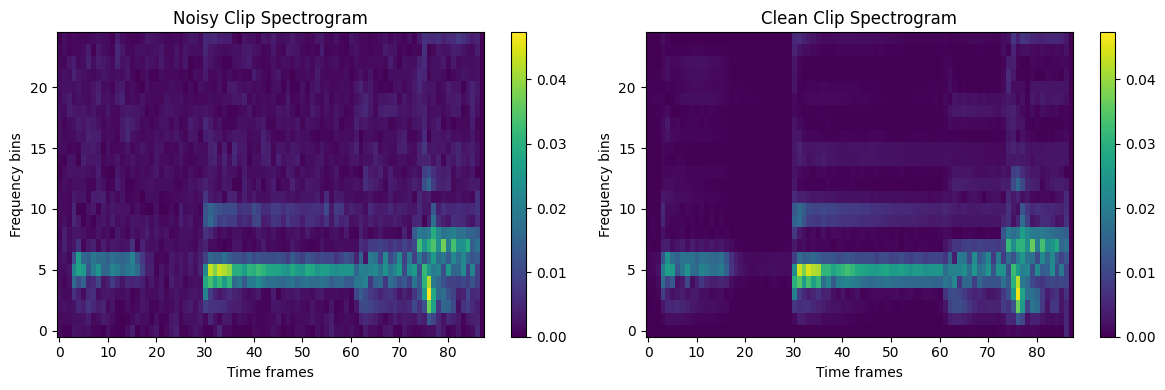

In [ ]:
n_bins = 25
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns
im0 = axes[0].imshow(S_noisy_clip[:n_bins], aspect="auto", origin="lower", interpolation="nearest")
axes[0].set_title("Noisy Clip Spectrogram")
axes[0].set_xlabel("Time frames")
axes[0].set_ylabel("Frequency bins")
plt.colorbar(im0, ax=axes[0])

im1 = axes[1].imshow(S_clip[:n_bins], aspect="auto", origin="lower", interpolation="nearest")
axes[1].set_title("Clean Clip Spectrogram")
axes[1].set_xlabel("Time frames")
axes[1].set_ylabel("Frequency bins")
plt.colorbar(im1, ax=axes[1])

vmin = min(S_clip.min(), S_noisy_clip.min())
vmax = max(S_clip.max(), S_noisy_clip.max())
im0.set_clim(vmin, vmax)
im1.set_clim(vmin, vmax)

plt.tight_layout()
plt.show()

Above looks structurally same , but as I zoom in i think there is pixel level differences due to noise

Time shift

In [ ]:
shifted_clip = song_guitar_clip[150:]  
S_shifted = spectrogram(shifted_clip, sample_rate_guitar)

score_shifted = normalized_template_match(S_guitar, S_shifted)
print("Template match score (shifted):", score_shifted)

Template match score (shifted): 0.9566296335806685


1. Okay so i didnt expect this to drop so much , though its still pretty decent . From my understanding STFT on the shifted clip would lead to a somewhat different spectogram , its not a linear transformation along X axis 
2. Another issue i see with this approach is that if i change the frequency space ( alter its speed ) then we are definetly doing a distortion over the space f x t => this would fail massively
3. So a pixel based matching algo is not scalable & would most definetly fail with distortion & noise

I think a better idea is to look for things in this spectogram that wont change , like the idea in the paper